# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.utils import shuffle
from time import time

dataset_dir = "datasets"

np.random.seed(1)
tf.set_random_seed(1)

In [2]:
from urllib.request import urlretrieve

source = "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

target = os.path.join(dataset_dir, "dataset.zip")

if not os.path.isfile(target):
    urlretrieve(source, target)
    print("Finished downloading datasets.")
else:
    print("Datasets have already been downloaded.")

Datasets have already been downloaded.


In [3]:
from zipfile import ZipFile

unzipped_exists = os.path.isdir(os.path.join(dataset_dir, "training"))

if not unzipped_exists:
    with ZipFile(target, "r") as zipped:
        zipped.extractall(dataset_dir)
    print("Finished extracting zip files.")
else:
    print("Unzipped files found - skipping.")

Unzipped files found - skipping.


In [4]:
# Load pickled data
import pickle

training_file = os.path.join(dataset_dir, "training", "train.p")
validation_file = os.path.join(dataset_dir, "training", "valid.p")
testing_file = os.path.join(dataset_dir, "training", "test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

preprocessed = False # Used to prevent us from preprocessing twice by mistake.

print("Loaded pickle files.")

Loaded pickle files.


Below, we create a dataset where signs are roughly equirepresented.
For now, we won't be using this training dataset, for two reasons:
1) Using it did not increase performance.
2) We should keep the data distribution similar between training and testing.

In [5]:
counts = np.bincount(y_train)

n_classes = len(np.unique(y_train))

label_to_inputs = {}

for i in range(n_classes):
    label_to_inputs[i] = X_train[y_train==i]

target_count_per_sign = 10000

def repeat_inputs(i):
    q = target_count_per_sign//counts[i]
    r = target_count_per_sign%counts[i]
    q_array = np.repeat(label_to_inputs[i], repeats=q, axis=0)
    r_array = label_to_inputs[i][np.random.choice(counts[i],r)]
    return np.concatenate((q_array,r_array), axis=0)

even_X_train = np.zeros([n_classes*target_count_per_sign, 32, 32, 3])

for i in range(n_classes):
    even_X_train[i*target_count_per_sign:(i+1)*target_count_per_sign] = repeat_inputs(i)

even_y_train = np.repeat(np.arange(n_classes), repeats=target_count_per_sign, axis=0)

even_X_train, even_y_train = shuffle(even_X_train, even_y_train)

Below, we define a few image transformations that will be used for preprocessing/augmenting the dataset.

In [6]:
def equalize(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0]) # equalize Y-channel
    equalized_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return equalized_img

def apply_blur(img):
    return cv2.GaussianBlur(img,(5,5),0)

def apply_homography(img):
    source_points = np.array([[12,16], [16,20], [20,16], [16,12]],np.float32)
    noise = np.random.normal(scale=0.2, size=source_points.shape)
    target_points = source_points + noise
    h, status = cv2.findHomography(source_points, target_points)
    im_out = cv2.warpPerspective(img, h, dsize=(32,32))
    return im_out

def apply_rotation(img):
    M = cv2.getRotationMatrix2D((16,16),np.random.uniform(-30,30),1)
    return cv2.warpAffine(img, M, (32,32))

def apply_noise(img):
    noise = np.random.normal(scale=3.0,size=img.shape)
    return np.clip(np.round(img + noise), 0.0, 256.0).astype(np.uint8)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [7]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

n_train = X_train.shape[0]

n_validation = X_valid.shape[0]

n_test = X_test.shape[0]

image_shape = X_train.shape[1:]

n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

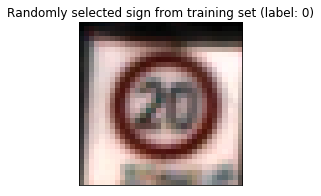

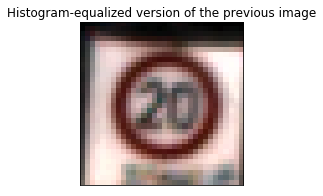

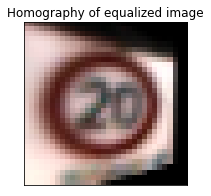

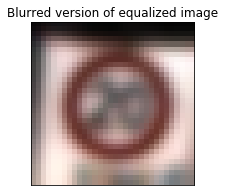

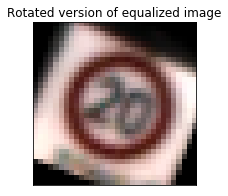

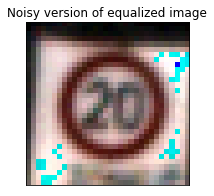

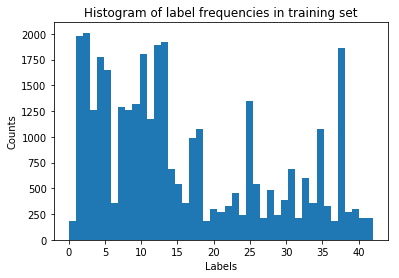

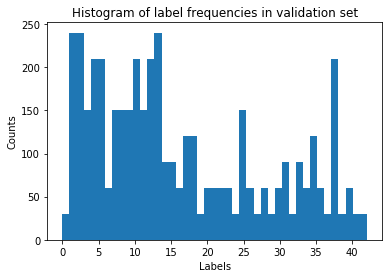

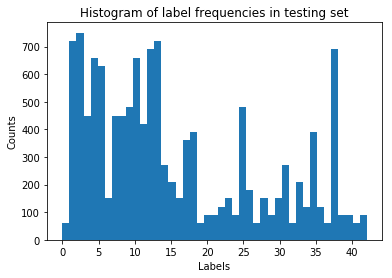

In [44]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random

index = random.randint(0, n_train-1) # upper bound is inclusive here
plt.figure(figsize=(3,3))
plt.title("Randomly selected sign from training set (label: {})".format(y_train[index]))
img = X_train[index]
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

equalized_img = equalize(img)

plt.figure(figsize=(3,3))
plt.title("Histogram-equalized version of the previous image".format(y_train[index]))
plt.imshow(equalized_img)
plt.xticks([])
plt.yticks([])
plt.show()

homography_example = apply_homography(equalized_img)

plt.figure(figsize=(3,3))
plt.title("Homography of equalized image".format(y_train[index]))
plt.imshow(homography_example)
plt.xticks([])
plt.yticks([])
plt.show()

blur = apply_blur(equalized_img)

plt.figure(figsize=(3,3))
plt.title("Blurred version of equalized image".format(y_train[index]))
plt.imshow(blur)
plt.xticks([])
plt.yticks([])
plt.show()

rotated = apply_rotation(equalized_img)

plt.figure(figsize=(3,3))
plt.title("Rotated version of equalized image".format(y_train[index]))
plt.imshow(rotated)
plt.xticks([])
plt.yticks([])
plt.show()

noisy = apply_noise(equalized_img)

plt.figure(figsize=(3,3))
plt.title("Noisy version of equalized image".format(y_train[index]))
plt.imshow(noisy)
plt.xticks([])
plt.yticks([])
plt.show()

label_dict = {
    "training": y_train,
    "validation": y_valid,
    "testing": y_test
}

for stage, y in label_dict.items():
    plt.hist(y, bins=n_classes)
    plt.title("Histogram of label frequencies in {} set".format(stage))
    plt.xlabel("Labels")
    plt.ylabel("Counts")
    plt.xticks(range(0, 43, 5))
    plt.show()

In [9]:
import csv

with open('signnames.csv', 'r') as csvfile:
    sign_reader = csv.reader(csvfile, delimiter=',')
    id_to_name = n_classes*[""]
    for row in sign_reader: # skip headers
        if row[0] == 'ClassId':
            continue
        id_to_name[int(row[0])] = row[1]
id_to_name = np.array(id_to_name)
for k,v in zip(range(n_classes), id_to_name):
    print(k, v)

0 Speed limit (20km/h)
1 Speed limit (30km/h)
2 Speed limit (50km/h)
3 Speed limit (60km/h)
4 Speed limit (70km/h)
5 Speed limit (80km/h)
6 End of speed limit (80km/h)
7 Speed limit (100km/h)
8 Speed limit (120km/h)
9 No passing
10 No passing for vehicles over 3.5 metric tons
11 Right-of-way at the next intersection
12 Priority road
13 Yield
14 Stop
15 No vehicles
16 Vehicles over 3.5 metric tons prohibited
17 No entry
18 General caution
19 Dangerous curve to the left
20 Dangerous curve to the right
21 Double curve
22 Bumpy road
23 Slippery road
24 Road narrows on the right
25 Road work
26 Traffic signals
27 Pedestrians
28 Children crossing
29 Bicycles crossing
30 Beware of ice/snow
31 Wild animals crossing
32 End of all speed and passing limits
33 Turn right ahead
34 Turn left ahead
35 Ahead only
36 Go straight or right
37 Go straight or left
38 Keep right
39 Keep left
40 Roundabout mandatory
41 End of no passing
42 End of no passing by vehicles over 3.5 metric tons


In [10]:
# Order signs by frequency (in training set)
counts = np.bincount(y_train)
sign_id_in_decreasing_frequency = np.argsort(counts)[::-1]
sign_names_in_decreasing_frequency = np.array([ id_to_name[x] for x in sign_id_in_decreasing_frequency])
print(sign_names_in_decreasing_frequency)

['Speed limit (50km/h)' 'Speed limit (30km/h)' 'Yield' 'Priority road'
 'Keep right' 'No passing for vehicles over 3.5 metric tons'
 'Speed limit (70km/h)' 'Speed limit (80km/h)' 'Road work' 'No passing'
 'Speed limit (100km/h)' 'Speed limit (120km/h)' 'Speed limit (60km/h)'
 'Right-of-way at the next intersection' 'Ahead only' 'General caution'
 'No entry' 'Wild animals crossing' 'Stop' 'Turn right ahead' 'No vehicles'
 'Traffic signals' 'Children crossing' 'Slippery road' 'Beware of ice/snow'
 'Turn left ahead' 'Vehicles over 3.5 metric tons prohibited'
 'End of speed limit (80km/h)' 'Bumpy road' 'Go straight or right'
 'Dangerous curve to the right' 'Roundabout mandatory' 'Double curve'
 'Keep left' 'Bicycles crossing' 'Road narrows on the right'
 'End of no passing by vehicles over 3.5 metric tons' 'End of no passing'
 'Pedestrians' 'End of all speed and passing limits'
 'Dangerous curve to the left' 'Go straight or left' 'Speed limit (20km/h)']


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [11]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

normalize_pixels = True
equalize_histograms = True

if (not preprocessed) and equalize_histograms:
    X_train = np.array([equalize(img) for img in X_train])
    X_valid = np.array([equalize(img) for img in X_valid])
    X_test = np.array([equalize(img) for img in X_test])

# We use the mean and standard deviation of the validation set (after histogram equalization)
v_mean = X_valid.mean()
v_std = X_valid.std()

def normalize(inp):
    out = (inp - v_mean)/v_mean
    return out

def preprocess(X): # will be used to preprocess other images (inconvenient to use here)
    if equalize_histograms:
        X = np.array([equalize(img) for img in X])
    if normalize_pixels:
        X = normalize(X)
    return X

if not preprocessed:
    # we defer normalization of X_train for augmentation purposes
    X_valid = normalize(X_valid)
    X_test = normalize(X_test)
    preprocessed = True
    print("Preprocessed all datasets.")
else:
    print("Datasets have already been preprocessed.")

Preprocessed all datasets.


We now augment the original training dataset to include homographies and blurred copies of the original images.

In [12]:
# No point in recomputing deterministic transformations
blurs = [apply_blur(x) for x in X_train]

def build_augmented_dataset():
    homographies = [apply_homography(x) for x in X_train]
    with_noise = [apply_noise(x) for x in X_train]
    rotated = [apply_rotation(x) for x in X_train]
    blurred_homographies = [apply_blur(x) for x in [apply_homography(xx) for xx in X_train]]
    to_stack = (X_train, rotated, with_noise, homographies, blurs, blurred_homographies)
    augmented_X_train = np.concatenate(to_stack, axis=0)
    augmented_y_train = np.concatenate(len(to_stack)*(y_train,),axis=0)
    augmented_X_train, augmented_y_train = shuffle(augmented_X_train, augmented_y_train)
    if normalize_pixels:
        augmented_X_train = normalize(augmented_X_train)
    return augmented_X_train, augmented_y_train

### Model Architecture

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

import math

init_weight_stddev = math.sqrt(2.0/(32*32*3)) # He-initialization

keep_prob_ = tf.placeholder(tf.float32, name="keep_prob")

def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))

layers = {}

def LeVandowskiNet(x): # because it starts with Le, and it is fired, get it?
    weights = {
        "conv1": tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 8), stddev=init_weight_stddev), name="w_conv1"),
        "conv2": tf.Variable(tf.truncated_normal(shape=(5, 5, 8, 8), stddev=init_weight_stddev), name="w_conv2"),
        "conv3": tf.Variable(tf.truncated_normal(shape=(5, 5, 8, 2), stddev=init_weight_stddev), name="w_conv3"),
        "fc1": tf.Variable(tf.truncated_normal(shape=(10*10*2, 160), stddev=init_weight_stddev), name="w_fc1"),
        "fc2": tf.Variable(tf.truncated_normal(shape=(160, 120), stddev=init_weight_stddev), name="w_fc2"),
        "fc3": tf.Variable(tf.truncated_normal(shape=(120, 80), stddev=init_weight_stddev), name="w_fc3"),
        "logits": tf.Variable(tf.truncated_normal(shape=(80, n_classes), stddev=init_weight_stddev), name="w_logits"),
    }
    
    biases = {
        "conv1": tf.Variable(tf.zeros(shape=(8,)), name="b_conv1"),
        "conv2": tf.Variable(tf.zeros(shape=(8,)), name="b_conv2"),
        "conv3": tf.Variable(tf.zeros(shape=(2,)), name="b_conv3"),
        "fc1": tf.Variable(tf.zeros(shape=(160,)), name="b_fc1"),
        "fc2": tf.Variable(tf.zeros(shape=(120,)), name="b_fc2"),
        "fc3": tf.Variable(tf.zeros(shape=(80,)), name="b_fc3"),
        "logits": tf.Variable(tf.zeros(shape=(n_classes,)), name="b_logits"),
    }
    
    conv1 = tf.nn.conv2d(x, weights["conv1"], strides=[1,1,1,1], padding="VALID")
    conv1 = tf.add(conv1, biases["conv1"])
    conv1 = selu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob_)
    
    conv2 = tf.nn.conv2d(conv1, weights["conv2"], strides=[1,1,1,1], padding="VALID")
    conv2 = tf.add(conv2, biases["conv2"])
    conv2 = selu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob_)
    
    conv3 = tf.nn.conv2d(conv2, weights["conv3"], strides=[1,2,2,1], padding="VALID")
    conv3 = tf.add(conv3, biases["conv3"])
    conv3 = selu(conv3)
    conv3 = tf.nn.dropout(conv3, keep_prob_)
    
    flattened = flatten(conv3)
    
    fc1 = tf.matmul(flattened, weights["fc1"])
    fc1 = tf.add(fc1, biases["fc1"])
    fc1 = selu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob_)
    
    fc2 = tf.matmul(fc1, weights["fc2"])
    fc2 = tf.add(fc2, biases["fc2"])
    fc2 = selu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob_)
    
    fc3 = tf.matmul(fc2, weights["fc3"])
    fc3 = tf.add(fc3, biases["fc3"])
    fc3 = selu(fc3)
    fc3 = tf.nn.dropout(fc3, keep_prob_)
    
    logits = tf.matmul(fc3, weights["logits"])
    logits = tf.add(logits, biases["logits"])
    
    global layers
    
    layers = {
        "input": x,
        "conv1": conv1,
        "conv2": conv2,
        "conv3": conv3,
        "flattened": flattened,
        "fc1": fc1,
        "fc2": fc2,
        "fc3": fc3,
        "logits": logits
    }
    
    for name, layer in layers.items():
        print("Shape of {}:".format(name), layer.get_shape())
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [14]:
# Here, we define the Tensorflow computation graph.
x_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name="x")
y_ = tf.placeholder(tf.int32, (None), name="y")
one_hot_y = tf.one_hot(y_, n_classes, name="one_hot_y")

learning_rate_ = tf.placeholder(tf.float32, name="learning_rate")

logits = LeVandowskiNet(x_)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate_)
training_operation = optimizer.minimize(loss_operation)

Shape of input: (?, 32, 32, 3)
Shape of conv1: (?, 28, 28, 8)
Shape of conv2: (?, 24, 24, 8)
Shape of conv3: (?, 10, 10, 2)
Shape of flattened: (?, 200)
Shape of fc1: (?, 160)
Shape of fc2: (?, 120)
Shape of fc3: (?, 80)
Shape of logits: (?, 43)


In [15]:
### Calculate and report the accuracy on the training and validation set.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, sess):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x_: batch_x, y_: batch_y, keep_prob_: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:
import matplotlib.pyplot as plt

from pandas_ml import ConfusionMatrix

def plot_confusion_matrix(y_data, y_predicted):
    confusion = ConfusionMatrix(y_data, y_predicted)
    confusion.plot()
    plt.show()

In [17]:
from sklearn.metrics import precision_recall_fscore_support as score

def get_metrics(y_data, y_predicted):
    precision, recall, fscore, support = score(y_data, y_predicted)
    pr = pd.DataFrame({
        "name": id_to_name,
        "precision": precision,
        "recall": recall,
        "support": support,
    })
    print(pr)

In [18]:
saver = tf.train.Saver()

session_dir = "sessions"

In [19]:
# Here, we train the model.
BATCH_SIZE = 128

timestamp = int(time())

if not os.path.exists(session_dir):
    os.makedirs(session_dir)
    
timestamped_session_dir = os.path.join(session_dir, str(timestamp))

if not os.path.exists(timestamped_session_dir):
    os.makedirs(timestamped_session_dir)

session_file = os.path.join(timestamped_session_dir, "LeVandowski.ckpt")

# num_epochs, learning_rate, keep_prob
scheduler = [(10, 0.001, 1.0),
             (10, 0.001, 0.9),
             (10, 0.0005, 0.8),
             (10, 0.0005, 0.7)]

max_validation_accuracy = 0.0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    global_epoch_count = 0
    for epochs, lr, kp in scheduler:
        x_data, y_data = build_augmented_dataset()
        for _ in range(epochs):
            for offset in range(0, num_examples, BATCH_SIZE):
                end = min(offset + BATCH_SIZE, num_examples)
                batch_x, batch_y = x_data[offset:end], y_data[offset:end]
                sess.run(
                    training_operation,
                    feed_dict={x_: batch_x, y_: batch_y, keep_prob_: kp, learning_rate_: lr}
                )
            training_accuracy = evaluate(x_data, y_data, sess) # with dropout desactivated
            validation_accuracy = evaluate(X_valid, y_valid, sess)
            if validation_accuracy > max_validation_accuracy:
                max_validation_accuracy = validation_accuracy
                saver.save(sess, session_file)

            print("EPOCH {} ...".format(global_epoch_count+1))
            print("Training Accuracy = {:.3f}".format(training_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
            global_epoch_count += 1
    
    print("Session saved as {}.".format(session_file))

Training...

EPOCH 1 ...
Training Accuracy = 0.665
Validation Accuracy = 0.681

EPOCH 2 ...
Training Accuracy = 0.830
Validation Accuracy = 0.856

EPOCH 3 ...
Training Accuracy = 0.866
Validation Accuracy = 0.881

EPOCH 4 ...
Training Accuracy = 0.891
Validation Accuracy = 0.898

EPOCH 5 ...
Training Accuracy = 0.908
Validation Accuracy = 0.898

EPOCH 6 ...
Training Accuracy = 0.914
Validation Accuracy = 0.904

EPOCH 7 ...
Training Accuracy = 0.914
Validation Accuracy = 0.903

EPOCH 8 ...
Training Accuracy = 0.924
Validation Accuracy = 0.913

EPOCH 9 ...
Training Accuracy = 0.924
Validation Accuracy = 0.901

EPOCH 10 ...
Training Accuracy = 0.924
Validation Accuracy = 0.907

EPOCH 11 ...
Training Accuracy = 0.933
Validation Accuracy = 0.938

EPOCH 12 ...
Training Accuracy = 0.940
Validation Accuracy = 0.937

EPOCH 13 ...
Training Accuracy = 0.944
Validation Accuracy = 0.946

EPOCH 14 ...
Training Accuracy = 0.941
Validation Accuracy = 0.938

EPOCH 15 ...
Training Accuracy = 0.946
Valid

INFO:tensorflow:Restoring parameters from sessions/1506372059/LeVandowski.ckpt
Session restored.


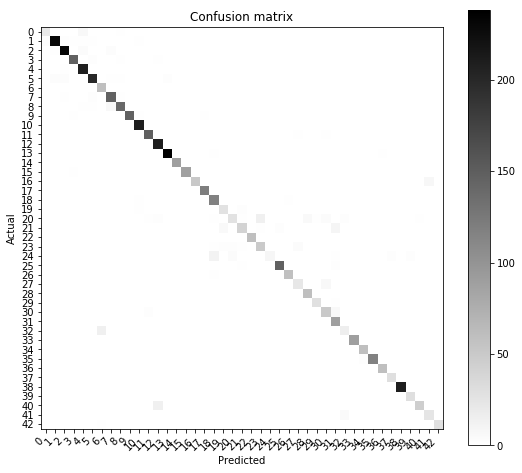

                                                 name  precision    recall  \
0                                Speed limit (20km/h)   0.880000  0.733333   
1                                Speed limit (30km/h)   0.982979  0.962500   
2                                Speed limit (50km/h)   0.970711  0.966667   
3                                Speed limit (60km/h)   0.979866  0.973333   
4                                Speed limit (70km/h)   0.941441  0.995238   
5                                Speed limit (80km/h)   0.970874  0.952381   
6                         End of speed limit (80km/h)   0.800000  1.000000   
7                               Speed limit (100km/h)   0.929936  0.973333   
8                               Speed limit (120km/h)   0.972414  0.940000   
9                                          No passing   1.000000  0.980000   
10       No passing for vehicles over 3.5 metric tons   0.981308  1.000000   
11              Right-of-way at the next intersection   0.980132

In [20]:
with tf.Session() as sess:
    # Restore session
    sessions = [os.path.join(session_dir, timestamp) for timestamp in os.listdir(session_dir)]
    latest_session = max(sessions, key=os.path.getctime)
    saver.restore(sess, os.path.join(latest_session, "LeVandowski.ckpt"))
    print("Session restored.")
    data_logits = sess.run(logits, feed_dict={x_: X_valid, keep_prob_: 1.0})
    y_predicted = np.array([ l.argmax() for l in data_logits])
    plot_confusion_matrix(y_valid, y_predicted)
    get_metrics(y_valid, y_predicted)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

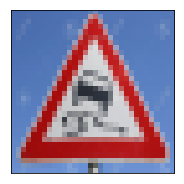

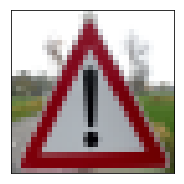

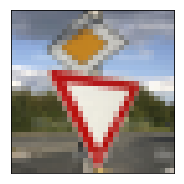

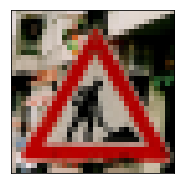

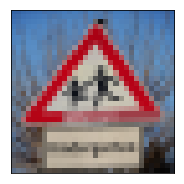

In [21]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

imgs = []

for i in range(1,6):
    filename = "examples/challenges/{}.jpg".format(i)
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA)
    imgs.append(resized)

imgs = np.stack(imgs)

for im in imgs:
    plt.figure(figsize=(3,3))
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    plt.show()

imgs = preprocess(imgs)

### Predict the Sign Type for Each Image

In [22]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    # Restore session
    sessions = [os.path.join(session_dir, timestamp) for timestamp in os.listdir(session_dir)]
    latest_session = max(sessions, key=os.path.getctime)
    saver.restore(sess, os.path.join(latest_session, "LeVandowski.ckpt"))
    print("Session restored.")
    data_logits = sess.run(logits, feed_dict={x_: imgs, keep_prob_: 1.0})
    y_predicted = np.array([ l.argmax() for l in data_logits])
    print(id_to_name[y_predicted])

INFO:tensorflow:Restoring parameters from sessions/1506372059/LeVandowski.ckpt
Session restored.
['Dangerous curve to the left' 'General caution' 'Yield' 'Road work'
 'Speed limit (30km/h)']


### Analyze Performance

In [46]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
y_real = np.array([23, 18, 13, 25, 28])

with tf.Session() as sess:
    # Restore session
    sessions = [os.path.join(session_dir, timestamp) for timestamp in os.listdir(session_dir)]
    latest_session = max(sessions, key=os.path.getctime)
    saver.restore(sess, os.path.join(latest_session, "LeVandowski.ckpt"))
    print("Session restored.")
    acc = sess.run(accuracy_operation, feed_dict={x_: imgs, y_: y_real, keep_prob_: 1.0})
    print("Accuracy:", acc)

INFO:tensorflow:Restoring parameters from sessions/1506372059/LeVandowski.ckpt
Session restored.
Accuracy: 0.6


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [47]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    # Restore session
    sessions = [os.path.join(session_dir, timestamp) for timestamp in os.listdir(session_dir)]
    latest_session = max(sessions, key=os.path.getctime)
    saver.restore(sess, os.path.join(latest_session, "LeVandowski.ckpt"))
    print("Session restored.")
    logit_values = sess.run(logits, feed_dict={x_: imgs, keep_prob_: 1.0})
    top_args = np.argsort(logit_values, axis=1)[:,::-1][:,:5]
    print(top_args)
    print([id_to_name[x] for x in top_args])

INFO:tensorflow:Restoring parameters from sessions/1506372059/LeVandowski.ckpt
Session restored.
[[19 23 27 11 26]
 [18 27 11 26 24]
 [13 18  9 38 17]
 [25 11 30 18 27]
 [ 1  5  0  7  2]]
[array(['Dangerous curve to the left', 'Slippery road', 'Pedestrians',
       'Right-of-way at the next intersection', 'Traffic signals'],
      dtype='<U50'), array(['General caution', 'Pedestrians',
       'Right-of-way at the next intersection', 'Traffic signals',
       'Road narrows on the right'],
      dtype='<U50'), array(['Yield', 'General caution', 'No passing', 'Keep right', 'No entry'],
      dtype='<U50'), array(['Road work', 'Right-of-way at the next intersection',
       'Beware of ice/snow', 'General caution', 'Pedestrians'],
      dtype='<U50'), array(['Speed limit (30km/h)', 'Speed limit (80km/h)',
       'Speed limit (20km/h)', 'Speed limit (100km/h)',
       'Speed limit (50km/h)'],
      dtype='<U50')]


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [45]:
with tf.Session() as sess:
    # Restore session
    sessions = [os.path.join(session_dir, timestamp) for timestamp in os.listdir(session_dir)]
    latest_session = max(sessions, key=os.path.getctime)
    saver.restore(sess, os.path.join(latest_session, "LeVandowski.ckpt"))
    print("Session restored.")
    test_accuracy = evaluate(X_test, y_test, sess)
    print("The test accuracy is {}.".format(test_accuracy))

INFO:tensorflow:Restoring parameters from sessions/1506372059/LeVandowski.ckpt
Session restored.
The test accuracy is 0.9275534439539966.


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [25]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input = preprocess(image_input) # deactivated, to prevent double preprocessing
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x_ : image_input, keep_prob_: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from sessions/1506372059/LeVandowski.ckpt
Session restored.


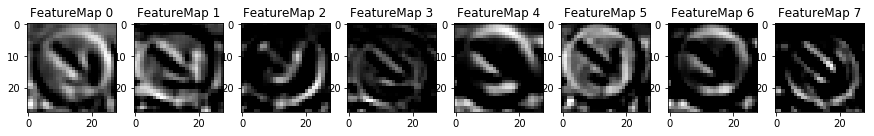

In [40]:
index = random.randint(0, n_train-1) # upper bound is inclusive here
image_in = np.array([X_train[index]])

with tf.Session() as sess:
    sessions = [os.path.join(session_dir, timestamp) for timestamp in os.listdir(session_dir)]
    latest_session = max(sessions, key=os.path.getctime)
    saver.restore(sess, os.path.join(latest_session, "LeVandowski.ckpt"))
    print("Session restored.")
    outputFeatureMap(image_in, layers["conv1"])